# Práctica 2 - CNN para clasificar imágenes de Rayos X de neumonía - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [74]:
"""Instalar pytorch con cuda"""
#%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

'Instalar pytorch con cuda'

#### Importar librerías de código

In [75]:
import torch # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import torchvision # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torchvision import datasets, transforms # type: ignore
from torch.utils.data import DataLoader, random_split # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


## CNN SetUp




### Preparación Dataset
En primer lugar, establecemos las rutas de los datasets

In [76]:
def preparar_dataset(ruta_dataset):
    ruta_train = os.path.join(ruta_dataset, "train")
    ruta_test = os.path.join(ruta_dataset, "test")

    if not os.path.exists(ruta_train) or not os.path.exists(ruta_test):
        print("Error al encontrar las rutas")
    else:
        print("Rutas cargadas correctamente")

    subcarpetas = [d for d in os.listdir(ruta_train) if os.path.isdir(os.path.join(ruta_train, d))]
    num_clases = len(subcarpetas)

    return ruta_train, ruta_test, subcarpetas, num_clases

ruta_train1, ruta_test1, subcarpetas1, num_clases1 = preparar_dataset(".\data\chest_xray")


Rutas cargadas correctamente


<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\david\AppData\Local\Temp\ipykernel_51204\3902522376.py:15: SyntaxWarning: invalid escape sequence '\d'
  ruta_train1, ruta_test1, subcarpetas1, num_clases1 = preparar_dataset(".\data\chest_xray")


Una vez tenemos las rutas establecidas, podemos proceder con el preprocesamiento del dataset. Lo primero que haremos será **normalizar** las imagenes. Para ello, convertiremos las imágenes a tensores (lo que sería convertirlo a matriz), y una vez convertido a tensor, las normalizaremos. Además, como las *etiquetas* de las imagenes vienen definidas por la carpeta en la que están contenidas, utilizaremos el método ImageFolders, el cual asignará la etiqueta a cada imagen **basandose en el nombre de la carpeta**.

In [77]:
def normalizar_dataset(ruta_train, ruta_test):
    transformer = transforms.Compose([
        # Convertimos las imágenes a escala de grises (1 canal), y redimensionamos a 100x100 píxeles
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    train_dataset = datasets.ImageFolder(root=ruta_train, transform=transformer)
    test_dataset = datasets.ImageFolder(root=ruta_test, transform=transformer)

    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size

    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    return train_subset, val_subset, test_dataset

train_subset1, val_subset1, test_dataset1 = normalizar_dataset(ruta_train1, ruta_test1)


##### Cuestión 1
**Enunciado:**

*Explica las funciones y el algoritmo para convertirlas a matrices. ¿Qué es cada matriz?
¿Qué tamaños tienen las imágenes? ¿Has normalizado? ¿Cómo y por qué?*

**Solución:**

Para que nuestra red neuronal pueda trabajar con imágenes en blanco y negro, debemos convertirlas a matrices.

A diferencia de las imágenes RGB, esta matriz sólo tendrá una dimensión, ya que carece de color, por lo que se podría decir que estamos trabajando con una escala de grises.

Por lo tanto, en este caso tendremos una matriz 100x100 de una dimensión (1, 100, 100).

La normalización tiene media de `0.5` y una desviación típica de `0.5`, lo que transforma los valores del rango `[0, 1]` al rango `[-1, 1]`, centrado en el 0, para mejorar la estabilidad y velocidad del entrenamiento.

A continuación, crearemos los DataLoaders, una estructura de pytorch que nos permitirá dividir los datasets por *lotes*, con el fin de tener un entrenamiento más eficiente.

In [ ]:
batch_size = 16

def DataLoaders(train_subset, val_subset, test_dataset, batch_size):
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

train_loader1, val_loader1, test_loader1 = DataLoaders(train_subset1, val_subset1, test_dataset1, batch_size)


### Implementación

Una vez hemos realizado el preprocesamiento de nuestro dataset, podemos proceder con la arquitectura de nuestra CNN.

#### Arquitectura de la CNN
La red convolucional tiene la siguiente composición:
- **Entrada:** imágenes en escala de grises, redimensionadas a `100x100`
- **Capa convolucional 1:** `Conv2D(1 → 4 filtros)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa convolucional 2:** `Conv2D(4 → 8)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa convolucional 3:** `Conv2D(8 → 16)` con kernel `3x3`, padding=1 + `ReLU` + `MaxPool2D(2x2)`
- **Capa densa:** `Linear(16×12×12 → 128)` + `ReLU`
- **Salida:** `Linear(128 → Número de clases)`
- **Función de activación final:** implícita con `CrossEntropyLoss` (usa softmax internamente)

Utilizamos RELU como función de activación, ya que es muy rápida de calcular y evita el problema del vanishing gradient. Además es ideal para activar las características extraídas por los filtros.

In [79]:
class CNN_PNEUMO(nn.Module):
    #Añadimos parámetros, con el fin de probar multiples arquitecturas y encontrar la mejor dentro de un rango
    def __init__(self, num_clases, out_channels, conv_kernel_size, pool_kernel_size, hidden_size):
        super(CNN_PNEUMO, self).__init__()

        self.capa1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.capa2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)

        self.capa3 = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels*4, kernel_size=conv_kernel_size, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2, padding=0)
        
        self.relu = nn.ReLU()

        #Calculamos de forma dinámica el tamaño de la flattened
        self.out_channels = out_channels
        self.flattened_size = self._get_flattened_size((1, 100, 100))

        self.fc1 = nn.Linear(out_channels*4 * 12 * 12, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_clases)

        
    #Calculo dinámico del tamaño de la flattened.
    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.pool1(self.relu(self.capa1(x)))
            x = self.pool2(self.relu(self.capa2(x)))
            x = self.pool3(self.relu(self.capa3(x)))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool1(self.relu(self.capa1(x)))
        x = self.pool2(self.relu(self.capa2(x)))
        x = self.pool3(self.relu(self.capa3(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    

Se entrenará el modelo con los siguientes parámetros:

- **Optimizador:** `Adam`
- **Función de pérdida:** `CrossEntropyLoss`
- **Criterio de parada:** `loss ≤ 0.2`
- **Número máximo de epochs:** `10`
- **Batch size:** `32`

El optimizador Adam es ideal ya que es robusto y suele converger más rápidamente que otros optimizadores como por ejemplo SGD.
Además, no exige demasiada configuración, lo que simplifica su implementación.

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterio = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
print(f'Modelo en: {device}')


Modelo en: cuda


Después, definimos la función de evaluación, para monitorizar la evolución del modelo en base a las dos tareas propuestas.

In [81]:
def validacion(model, val_loader, criterio):
    model.eval() 
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterio(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    return val_loss / len(val_loader), val_accuracy 


###Entrenamiento tarea 1 (tipos de pneumonía)
Procedemos a entrenar la red con el dataset de entrenamiento para la tarea de distinguir entre diferentes tipos de pneumonía.

In [82]:
def entrenamiento(model, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterio(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        #if epoch_loss < 0.2:
        #    print(f"Aprendizaje completado. {epoch_loss:.4f} < 0.2")
        #    break
        
        val_loss, val_accuracy = validacion(model, val_loader, criterio)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    torch.cuda.empty_cache()
    return model, train_losses, train_accuracies, val_accuracies, val_losses 


Para obtener el mejor modelo posible, entrenaremos el modelo con distintos learning rates, y con algun retoque de parámetros.

Probaremos un rango de learning rates, desde 0.01 hasta 0.0001, y tocaremos los out_channels y los kernel_sizes para obtener el mejor modelo posible.

In [83]:
def experimentar_parametros(train_loader, val_loader, num_classes, epochs=4):
    #Definimos las combinaciones de modelos a probar
    combinaciones = [
        {'lr': 0.001, 'out_channels': 4, 'kernel_size': 3, 'pool_kernel_size': 2, 'hidden_size': 128},  # Config original
        {'lr': 0.0001, 'out_channels': 8, 'kernel_size': 3, 'pool_kernel_size': 2, 'hidden_size': 128},
        {'lr': 0.001, 'out_channels': 16, 'kernel_size': 3, 'pool_kernel_size': 2, 'hidden_size': 128},
    ]
    
    resultados = []
    modelos = []

    
    
    # Probar cada combinación
    for i, config in enumerate(combinaciones):
        lr = config['lr']
        out_channels = config['out_channels']
        kernel_size = config['kernel_size']
        pool_kernel_size = config['pool_kernel_size']
        hidden_size = config['hidden_size']
        
        print(f"\n[Experimento {i+1}/{len(combinaciones)}]")
        print(f"Configuración: lr={lr}, out_channels={out_channels}, kernel_size={kernel_size}, " + 
              f"pool_kernel_size={pool_kernel_size}, hidden_size={hidden_size}")
        
        #Definimos el modelo con su combinacion correspondiente de parámetros
        model = CNN_PNEUMO(
            num_classes, 
            out_channels=out_channels, 
            conv_kernel_size=kernel_size, 
            pool_kernel_size=pool_kernel_size,
            hidden_size=hidden_size
        ).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        #Entrenamos el modelo
        model, train_losses, train_accs, val_accs, val_losses = entrenamiento(
            model, optimizer, train_loader, val_loader, epochs=epochs
        )
        
        resultado = {
            'lr': lr,
            'out_channels': out_channels,
            'kernel_size': kernel_size,
            'pool_kernel_size': pool_kernel_size,
            'hidden_size': hidden_size,
            'train_loss_final': train_losses[-1],
            'val_loss_final': val_losses[-1],
            'train_acc_final': train_accs[-1],
            'val_acc_final': val_accs[-1]
        }
        resultados.append(resultado)
        modelos.append(model)
    
    #Buscamos la mejor combinación, basándonos en el accuraccy y loss de la validación de cada modelo
    max_val_acc = max(r['val_acc_final'] for r in resultados)
    candidatos = [i for i, r in enumerate(resultados) if r['val_acc_final'] == max_val_acc]
    
    mejor_idx = min(candidatos, key=lambda i: resultados[i]['val_loss_final'])
    
    mejor_modelo = modelos[mejor_idx]
    mejores_resultados = resultados[mejor_idx]

    return mejor_modelo, mejores_resultados

### Gráficos de entrenamiento del mejor modelo
Definimos la función que mostrará en un plot los resultados obtenidos tanto en el entrenamiento como en la validación del mejor modelo encontrado

In [84]:
def graficar_entrenamiento(model, train_losses, train_accuracies, val_accuracies, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Pérdida de entrenamiento", color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Pérdida de validación", color='red', linestyle='dashed')
    plt.title("Evolución de la Pérdida durante el Entrenamiento")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Precisión de entrenamiento", color='green')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Precisión de validación", color='orange', linestyle='dashed')
    plt.title("Evolución de la Precisión durante el Entrenamiento")
    plt.xlabel("Época")
    plt.ylabel("Precisión (%)")
    plt.legend()
    plt.show()

Una vez definidas todas las funciones, procedemos a entrenar las distintas arquitecturas o experimentos, para encontrar aquel modelo que sea el más eficiente, preciso y con menos error.

En primer lugar, buscaremos el mejor modelo para el caso de clasificar entre Normal y Pneumonía.

In [85]:
print("**************************************")
print("\nClasificar entre Normal vs Pneumonía")
print("**************************************\n")

print("Experimentando con parámetros para el modelo Normal vs Pneumonia:")
mejor_modelo_sano_enfermo, resultados1 = experimentar_parametros(
    train_loader1, val_loader1, num_clases1
)
print(resultados1)
torch.save(mejor_modelo_sano_enfermo.state_dict(), 'modelo_sano_enfermo.pth')

print("Modelo NORMAL vs PNEUMONIA guardado.")


**************************************

Clasificar entre Normal vs Pneumonía
**************************************

Experimentando con parámetros para el modelo Normal vs Pneumonia:

[Experimento 1/3]
Configuración: lr=0.001, out_channels=4, kernel_size=3, pool_kernel_size=2, hidden_size=128
Epoch [1/4], Loss: 0.2199, Accuracy: 91.25%
Epoch [2/4], Loss: 0.1258, Accuracy: 95.38%
Epoch [3/4], Loss: 0.0982, Accuracy: 96.33%
Epoch [4/4], Loss: 0.0803, Accuracy: 97.22%

[Experimento 2/3]
Configuración: lr=0.0001, out_channels=8, kernel_size=3, pool_kernel_size=2, hidden_size=128
Epoch [1/4], Loss: 0.4272, Accuracy: 80.90%
Epoch [2/4], Loss: 0.1488, Accuracy: 94.44%
Epoch [3/4], Loss: 0.1208, Accuracy: 95.49%
Epoch [4/4], Loss: 0.1109, Accuracy: 95.66%

[Experimento 3/3]
Configuración: lr=0.001, out_channels=16, kernel_size=3, pool_kernel_size=2, hidden_size=128
Epoch [1/4], Loss: 0.1829, Accuracy: 93.15%
Epoch [2/4], Loss: 0.0962, Accuracy: 96.43%
Epoch [3/4], Loss: 0.0644, Accuracy: 97.72

#### Cuestión 3

Para abordar esta pregunta, debemos entrenar un modelo que clasifique tres categorías. Utilizaremos los parámetros obtenidos por el mejor modelo de Normal vs Pneumonía para ahorrar tiempo de entrenamiento.

A la hora de realizar dos clasificaciones diferentes, existía la posibilidad de usar un solo modelo que tuviese dos salidas en vez de una, distinguiendo entre tareas. Este modelo tendría dos capas de salida en vez de una sola `self.fc2`. Este método, que a priori parece más eficiente en cuanto a complejidad de código y recursos, se descartó debido a los siguientes motivos:
- Disponer de un modelo para cada clasificación provoca que cada modelo pueda especializarse mejor a la tarea asignada. Ambos modelos utilian la misma arquitectura, con la diferencia de que sus salidas difieren.
- Mejor flexibilidad por tarea: Al separar los modelos, conseguimos ajustar los hiperparámetros por separado, para encontrar aquellos que mejor se ajusten a cada tarea. Esto facilita encontrar errores que no podríamos detectar si usásemos un solo modelo para ambas tareas.
- Disponibilidad de CUDA: Al poder utilizar CUDA, el entrenamiento se finalizaba en cuestión de pocos minutos, por lo que nos podemos permitir realizar dos entrenamientos en vez de uno solo.

Por todo ello, se han generalizado las funciones para entrenar dos modelos como si fuesen diferentes, aunque en realidad usen el mismo dataset pero reestructurado de manera diferente.

En cuanto a ver cual de las tareas es más fácil, usaremos Matrices de Confusión, y compararemos los resultados de accuraccy y loss para ver cual se comporta mejor.
Las *Matrices de Confusión* se utilizan para ver como se comporta un modelo con respecto a las clases que debe encontrar. Sirven para observar de manera visual en qué clases de estan equivocando más los modelos.

###Entrenamiento de la red que distingue entre pneumonías

Esta red será entrenada de la misma forma que el primer modelo, con la diferencia de que su dataset contendrá tres clases o categorías (Normal, Bcteriana, Viral) en vez de dos (Normal, Pneumonía). Usaremos, por tanto, un dataset que contiene los mismos individuos, pero que se ha reorganizado para tener tres subcarpetas en vez de dos.

Como hemos generalizado todas las funciones, las volvemos a llamar para entrenar este nuevo modelo.

Para crear el dataset nuevo, hemos creado una copia del ya existente aplicando este código comentado:

In [86]:
"""
import shutil

def reorganizar_dataset(base_path):

    for split in ['train', 'val', 'test']:
        #Nos interesa trabajar con los datos de la carpeta PNEUMONIA
        pneumonia_path = os.path.join(base_path, split, 'PNEUMONIA')

        #Estas serán las nuevas subcarpetas
        viral_path = os.path.join(base_path, split, 'VIRAL')
        bacterial_path = os.path.join(base_path, split, 'BACTERIAL')
        os.makedirs(viral_path, exist_ok=True)
        os.makedirs(bacterial_path, exist_ok=True)

        
        for img in os.listdir(pneumonia_path):
            src = os.path.join(pneumonia_path, img)
            #Si aparece la palabra 'virus' en el título de la imagen, la metemos en la subcarpeta VIRAL
            if 'virus' in img.lower():
                dst = os.path.join(viral_path, img)
            else:
                #Si no aparece la palabra 'virus' en el título de la imagen, se trata de una imagen bacteriana
                # que meteremos en la subcarpeta BACTERIAL
                dst = os.path.join(bacterial_path, img)
            shutil.move(src, dst)
        
        #Las imágenes de NORMAL no nos interesa moverlas.
        if not os.listdir(pneumonia_path):
            os.rmdir(pneumonia_path)

#Creamos un nuevo dataset a partir de una copia del original
reorganizar_dataset('./chest_xray_copy')
"""

"\nimport shutil\n\ndef reorganizar_dataset(base_path):\n\n    for split in ['train', 'val', 'test']:\n        #Nos interesa trabajar con los datos de la carpeta PNEUMONIA\n        pneumonia_path = os.path.join(base_path, split, 'PNEUMONIA')\n\n        #Estas serán las nuevas subcarpetas\n        viral_path = os.path.join(base_path, split, 'VIRAL')\n        bacterial_path = os.path.join(base_path, split, 'BACTERIAL')\n        os.makedirs(viral_path, exist_ok=True)\n        os.makedirs(bacterial_path, exist_ok=True)\n\n        \n        for img in os.listdir(pneumonia_path):\n            src = os.path.join(pneumonia_path, img)\n            #Si aparece la palabra 'virus' en el título de la imagen, la metemos en la subcarpeta VIRAL\n            if 'virus' in img.lower():\n                dst = os.path.join(viral_path, img)\n            else:\n                #Si no aparece la palabra 'virus' en el título de la imagen, se trata de una imagen bacteriana\n                # que meteremos en l

In [87]:
#Usamos el dataset 'alterado', dividido en subcarpetas diferentes
ruta_train2, ruta_test2, subcarpetas2, num_clases2 = preparar_dataset(".\data\chest_xray_copy")

#Normalizamos el dataset nuevo
train_subset2, val_subset2, test_dataset2 = normalizar_dataset(ruta_train2, ruta_test2)

#Creamos sus respectivos DataLoaders
train_loader2, val_loader2, test_loader2 = DataLoaders(train_subset2, val_subset2, test_dataset2, batch_size)

print("*********************************************")
print("Clasificar entre Normal vs Bacterial vs Viral")
print("*********************************************\n")

print("Experimentando con parámetros para el modelo Normal vs Bacterial vs Viral:")
mejor_modelo_tipos_pneumo, resultados2 = experimentar_parametros(
    train_loader2, val_loader2, num_clases2
)
print(resultados2)
torch.save(mejor_modelo_tipos_pneumo.state_dict(), 'modelo_tipos_pneumo.pth')

print("Modelo NORMAL vs BACTERIAL vs VIRAL guardados")


Rutas cargadas correctamente
**************************************

Clasificar entre Normal vs Bacterial vs Viral
**************************************

Experimentando con parámetros para el modelo Normal vs Bacterial vs Viral:

[Experimento 1/3]
Configuración: lr=0.001, out_channels=4, kernel_size=3, pool_kernel_size=2, hidden_size=128


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\david\AppData\Local\Temp\ipykernel_51204\3701412290.py:2: SyntaxWarning: invalid escape sequence '\d'
  ruta_train2, ruta_test2, subcarpetas2, num_clases2 = preparar_dataset(".\data\chest_xray_copy")


Epoch [1/4], Loss: 0.6632, Accuracy: 70.88%
Epoch [2/4], Loss: 0.5415, Accuracy: 76.08%
Epoch [3/4], Loss: 0.5090, Accuracy: 77.45%
Epoch [4/4], Loss: 0.4853, Accuracy: 78.34%

[Experimento 2/3]
Configuración: lr=0.0001, out_channels=8, kernel_size=3, pool_kernel_size=2, hidden_size=128
Epoch [1/4], Loss: 0.8901, Accuracy: 60.00%
Epoch [2/4], Loss: 0.6149, Accuracy: 73.62%
Epoch [3/4], Loss: 0.5659, Accuracy: 75.03%
Epoch [4/4], Loss: 0.5380, Accuracy: 76.49%

[Experimento 3/3]
Configuración: lr=0.001, out_channels=16, kernel_size=3, pool_kernel_size=2, hidden_size=128
Epoch [1/4], Loss: 0.6355, Accuracy: 71.46%
Epoch [2/4], Loss: 0.4969, Accuracy: 78.31%
Epoch [3/4], Loss: 0.4612, Accuracy: 79.37%
Epoch [4/4], Loss: 0.4195, Accuracy: 81.26%
{'lr': 0.001, 'out_channels': 16, 'kernel_size': 3, 'pool_kernel_size': 2, 'hidden_size': 128, 'train_loss_final': 0.4194915267813708, 'val_loss_final': 0.4732770122813456, 'train_acc_final': 81.26048406422238, 'val_acc_final': 78.71524448705657}
M

Una vez tenemos todos los datos, los mostramos en una tabla de comparación. Primero, asignamos los resultados a sus variables, para facilitar el trabajo.

In [ ]:
#Asignamos los resultados a sus correspondientes variables.
train_losses1 = resultados1['train_loss_final']
train_accuracies1 = resultados1['train_acc_final']
val_losses1 = resultados1['val_loss_final']
val_accuracies1 = resultados1['val_acc_final']

train_losses2 = resultados2['train_loss_final']
train_accuracies2 = resultados2['train_acc_final']
val_losses2 = resultados2['val_loss_final']
val_accuracies2 = resultados2['val_acc_final']


Veamos que tal predice cada modelo, para decidirnos por cual de los dos es más fácil y preciso. Utilizaremos para ello la matriz de confusión, para ver el grado de acierto de cada modelo.

********************************************
Evaluación del Modelo de Normal vs PNEUMONIA
********************************************

Accuracy en test: 0.7436
['NORMAL', 'PNEUMONIA']


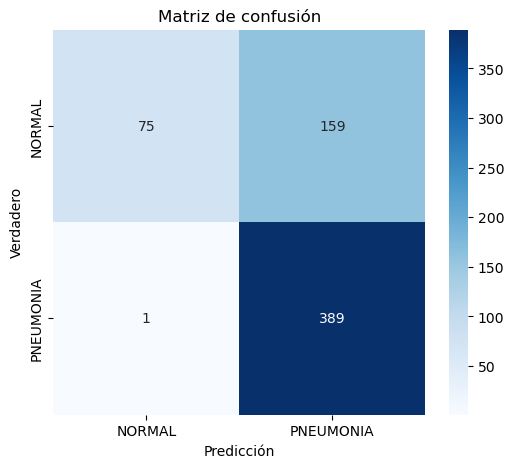

Accuracy en test: 0.7260
['BACTERIAL', 'NORMAL', 'VIRAL']


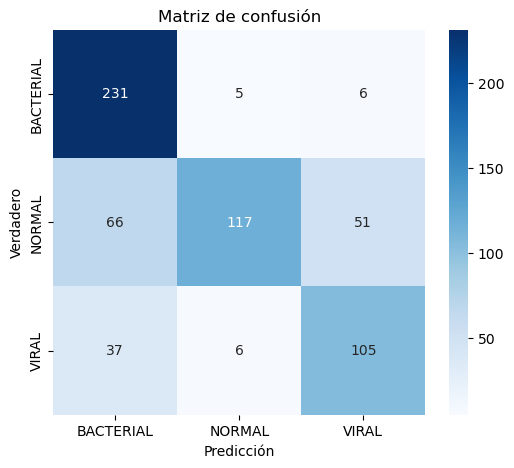

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, device, test_dataset):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy en test: {acc:.4f}")
    #Visualizamos la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.title("Matriz de confusión")
    plt.show()

    return y_true, y_pred
print("********************************************")
print("Evaluación del Modelo de Normal vs PNEUMONIA")
print("********************************************\n")
y_true1, y_pred1 = evaluate_model(mejor_modelo_sano_enfermo, test_loader1, device, test_dataset1)
y_true1, y_pred1 = evaluate_model(mejor_modelo_tipos_pneumo, test_loader2, device, test_dataset2)


##Conclusiones

Observando los resultados, podemos afirmar que el modelo de detectar si estas sano o no es mucho más fácil, preciso y eficiente que el de detectar entre si estas sano, tienes pneumonía bacterial o pneumonía viral. Nos hemos apoyado tanto en los resultados y la matriz de confusión, como en la propia biología.

A un médico real no le supone esfuerzo alguno detectar si una persona está sana o tiene algun tipo de pneumonía, ya que un pulmón sano no tiene ningún tipo de perturbación en las imágenes de rayos x. Sin embargo, a la hora de distinguir entre tipos de pneumonía, un médico suele fallar la mayoría de las veces. Esto se debe a queambos tipos comparten similitudes, y a veces es muy dificil diferenciarlos.

Creemos que el modelo también, de algún modo, encuentra estas dificultades a la hora de clasificar.

En la evaluación, vemos como el primer modelo falla demasiado a la hora de clasificar los individuos con Pneumpnía, mientras que en el segundo modelo

###Cuestion 4

En el caso de que nos encontremos con una escasez de imágenes que posiblemente provoque overfitting en nuestro modelo, podemos utilizar varias técnicas. Es muy común en medicina verse afectado por este problema. 

Para resolverlo, vamos a utilizar el llamado 'Data Augmentation', que consiste en añadir más imágenes que simplemente son variaciones de las ya existentes. Se pueden girar, dar la vuelta, redimensionar o cambiar de color, con el fin de hacer creer al modelo que es una imagen nueva, reforzando así su capacidad de generalizar.

Vemos que, según los resultados sobre todo del primer modelo (Sano o Enfermo), los resultados son excesivamente perfectos, lo que puede significar que hemos caído en el overfitting. Para arreglar este problema, utilizaremos un transformador, para añadir más imágenes al dataset como ya hemos explicado anteriormente.

Si esta técnica no resulta efectiva, aplicaremos dropout, apagando aleatoriamente algunas neuronas durante el entrenamiento para lograr que el modelo aprenda "con un ojo tapado".